In [ ]:
# Unzip del dataset descargado
!unzip /content/archive.zip

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [1]:
# Importar las librerias
# Network Intrusion Detection with PyTorch (Simple Neural Network)
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('/content/Cyberattacks Detection.csv')

In [4]:
df.shape

(13790, 16)

Se trata de un dataset de 16 columnas con 100 mil registros asociado a ciberataques.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13790 entries, 0 to 13789
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Attack ID             13782 non-null  float64
 1   Source IP             13785 non-null  object 
 2   Destination IP        13782 non-null  object 
 3   Source Country        13787 non-null  object 
 4   Destination Country   13781 non-null  object 
 5   Protocol              13779 non-null  object 
 6   Source Port           13783 non-null  float64
 7   Destination Port      13781 non-null  float64
 8   Attack Type           13778 non-null  object 
 9   Payload Size (bytes)  13782 non-null  float64
 10  Detection Label       13781 non-null  object 
 11  Confidence Score      13776 non-null  float64
 12  ML Model              13780 non-null  object 
 13  Affected System       13785 non-null  object 
 14  Port Type             13777 non-null  object 
 15  Timestamp          

Notamos que unicamente el campo de tiempo tiene gran cantidad de datos vacios, sin embargo esta columna no se la utilizara, ademas notamos que en base a https://cybermap.kaspersky.com/es el numero de ataques se da cada 41 segundos en promedio, con lo cual concluimos que no es relevante.

In [6]:
# En primer lugar se elimino la columna de tiempo
df= df.drop(columns=['Timestamp'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13790 entries, 0 to 13789
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Attack ID             13782 non-null  float64
 1   Source IP             13785 non-null  object 
 2   Destination IP        13782 non-null  object 
 3   Source Country        13787 non-null  object 
 4   Destination Country   13781 non-null  object 
 5   Protocol              13779 non-null  object 
 6   Source Port           13783 non-null  float64
 7   Destination Port      13781 non-null  float64
 8   Attack Type           13778 non-null  object 
 9   Payload Size (bytes)  13782 non-null  float64
 10  Detection Label       13781 non-null  object 
 11  Confidence Score      13776 non-null  float64
 12  ML Model              13780 non-null  object 
 13  Affected System       13785 non-null  object 
 14  Port Type             13777 non-null  object 
dtypes: float64(5), obje

Luego de analizar el dataset nos dimos cuenta que nuestra columna resultado al momento de entrenar un modelo seria la de Attack Type dado que nos indica el tipo de ataque reconocido en base a las demas columnas.

In [8]:
df.groupby('Attack Type').size()

Attack Type
Advanced Persistent Threat (APT)                    689
Brute Force                                         721
Credential Stuffing                                 701
Cross-Site Scripting (XSS) Attack                   692
Cryptojacking                                       687
DNS Tunneling                                       684
Distributed Denial of Service (DDoS)                712
Drive-by Download                                   666
Email Spam                                          697
File Transfer Protocol (FTP) Attack                 635
Insider Threat                                      737
Malware                                             729
Man-in-the-Middle (MITM)                            687
Phishing                                            718
Ping of Death                                       695
Remote Desktop Protocol (RDP) Attack                648
SQL Injection                                       661
Simple Network Management Protocol (SNMP) Attack    662
Watering Hole Attack                                680
Zero-Day Exploit                                    677
dtype: int64

In [9]:
# Eliminaremos los duplicados y valores infinitos
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df_siNIP = df.drop(['Source IP', 'Destination IP'], axis=1)
for col in df_siNIP.select_dtypes(include=['object']).columns:
    df_siNIP[col] = LabelEncoder().fit_transform(df_siNIP[col])

sns.heatmap(df_siNIP[:200].corr(), cmap='coolwarm')
plt.show()
# Con este codigo lo que se hizo fue pasar el los valores objet o label a numeros con labelencoder, en este caso no se utilizo el le.fit dado que consumia demasiada RAM

En base al Grafico se pudo notar que existe mayor correlacion a nuestra Variable AttackType en base a El SIstema afectado (Affected System)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13666 entries, 0 to 13788
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Attack ID             13666 non-null  float64
 1   Source IP             13666 non-null  object 
 2   Destination IP        13666 non-null  object 
 3   Source Country        13666 non-null  object 
 4   Destination Country   13666 non-null  object 
 5   Protocol              13666 non-null  object 
 6   Source Port           13666 non-null  float64
 7   Destination Port      13666 non-null  float64
 8   Attack Type           13666 non-null  object 
 9   Payload Size (bytes)  13666 non-null  float64
 10  Detection Label       13666 non-null  object 
 11  Confidence Score      13666 non-null  float64
 12  ML Model              13666 non-null  object 
 13  Affected System       13666 non-null  object 
 14  Port Type             13666 non-null  object 
dtypes: float64(5), object(10

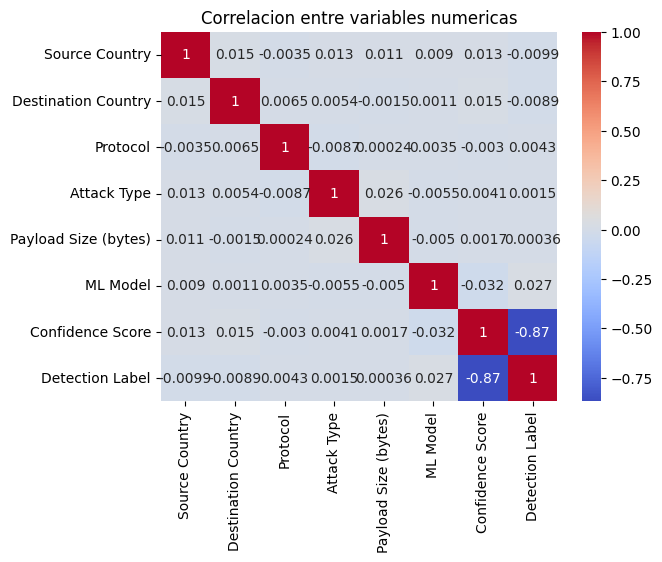

In [13]:
sns.heatmap(df_siNIP[['Source Country', 'Destination Country', 'Protocol', 'Attack Type', 'Payload Size (bytes)', 'ML Model','Confidence Score','Detection Label']].corr(), cmap='coolwarm', annot=True)
plt.title('Correlacion entre variables numericas')
plt.show()

En base a las Ips deseamos incluir dos columnas que incluyan el tipo de IP publica o privada, para esto hacemos uso de la libreria ipaddres creando una funcion que nos devuelva un dataframe llamado "df_ips"

In [14]:
import pandas as pd
import ipaddress

# Dataset de ejempl


# Función para clasificar IP
def tipo_ip(ip):
    try:
        return "Privada" if ipaddress.ip_address(ip).is_private else "Pública"
    except ValueError:
        return "Inválida"

# Creamos un nuevo DataFrame copiando el original
df_ips = df.copy()

# Insertar columna después de "Source IP"
df_ips.insert(df_ips.columns.get_loc("Source IP") + 1,
              "Source IP Tipo",
              df_ips["Source IP"].apply(tipo_ip))

# Insertar columna después de "Destination IP"
df_ips.insert(df_ips.columns.get_loc("Destination IP") + 1,
              "Destination IP Tipo",
              df_ips["Destination IP"].apply(tipo_ip))

# Mostrar nuevo DataFrame
print(df_ips.to_string())

       Attack ID        Source IP Source IP Tipo   Destination IP Destination IP Tipo Source Country Destination Country Protocol  Source Port  Destination Port                                       Attack Type  Payload Size (bytes) Detection Label  Confidence Score                ML Model     Affected System Port Type
0            1.0   68.156.227.194        Pública   194.91.121.112             Pública          India                 USA     ICMP      16824.0           53410.0                                       Brute Force                3936.0        Detected          0.600507     K-Nearest Neighbors       Cloud Storage     Other
1            2.0   249.221.229.41        Privada    3.207.120.235             Pública        Germany                 USA      TCP      23977.0           31745.0                  Advanced Persistent Threat (APT)                2870.0        Detected          0.524150     K-Nearest Neighbors      Network Router     Other
2            4.0   154.55.209.171    

In [15]:
df_ips

Attack ID        Source IP Source IP Tipo   Destination IP  \
0            1.0   68.156.227.194        Pública   194.91.121.112   
1            2.0   249.221.229.41        Privada    3.207.120.235   
2            4.0   154.55.209.171        Pública    132.115.33.82   
3            5.0    106.61.204.27        Pública     40.61.49.130   
4            6.0  144.190.250.125        Pública     34.68.66.192   
...          ...              ...            ...              ...   
13784    15227.0    38.237.99.102        Pública   251.45.179.157   
13785    15228.0   169.184.180.93        Pública    191.13.68.118   
13786    15229.0     188.2.68.106        Pública  152.124.229.240   
13787    15230.0   40.253.111.120        Pública    154.88.58.220   
13788    15231.0    182.60.168.17        Pública   133.122.188.52   

      Destination IP Tipo Source Country Destination Country Protocol  \
0                 Pública          India                 USA     ICMP   
1                 Pública        Germany                 USA      TCP   
2                 Pública            USA               China      UDP   
3                 Pública         France              France      UDP   
4                 Pública    South Korea             Germany      TCP   
...                   ...            ...                 ...      ...   
13784             Privada         Brazil         South Korea      TCP   
13785             Pública         Brazil              Russia     ICMP   
13786             Pública         Russia               Japan      UDP   
13787             Pública         France               India      TCP   
13788             Pública          Japan                  UK      UDP   

       Source Port  Destination Port                        Attack Type  \
0          16824.0           53410.0                        Brute Force   
1          23977.0           31745.0   Advanced Persistent Threat (APT)   
2          36556.0           38880.0  Cross-Site Scripting (XSS) Attack   
3          14724.0           21669.0                     Insider Threat   
4          44693.0            6474.0               Watering Hole Attack   
...            ...               ...                                ...   
13784      39208.0           47509.0                Credential Stuffing   
13785      41197.0             977.0                            Malware   
13786       7523.0            9871.0                           Phishing   
13787      29354.0           35391.0                      Ping of Death   
13788      48382.0           26815.0           Man-in-the-Middle (MITM)   

       Payload Size (bytes) Detection Label  Confidence Score  \
0                    3936.0        Detected          0.600507   
1                    2870.0        Detected          0.524150   
2                    3833.0    Not Detected          0.238944   
3                    4301.0    Not Detected          0.122334   
4                    4569.0        Detected          0.970895   
...                     ...             ...               ...   
13784                  19.0    Not Detected          0.176086   
13785                 389.0    Not Detected          0.243001   
13786                2751.0    Not Detected          0.466981   
13787                3532.0    Not Detected          0.444064   
13788                4420.0    Not Detected          0.395014   

                     ML Model     Affected System Port Type  
0         K-Nearest Neighbors       Cloud Storage     Other  
1         K-Nearest Neighbors      Network Router     Other  
2              Neural Network         Workstation     Other  
3              Neural Network         Workstation     Other  
4              Neural Network  Application Server     Other  
...                       ...                 ...       ...  
13784  Support Vector Machine        Email Server     Other  
13785          Neural Network     Database Server     Other  
13786  Support Vector Machine          IoT Device     Other  

Podemos ver que existe mayor numero de Ips Publicas asociadas a estos ataques tanto en ips de destino como de origen Lo cual es un comportamiento esperado

In [16]:
df_ips.groupby("Source IP Tipo").size().reset_index(name="cantidad")


Source IP Tipo  cantidad
0        Privada      1048
1        Pública     12618

In [17]:
df_ips.groupby("Destination IP Tipo").size().reset_index(name="cantidad")

Destination IP Tipo  cantidad
0             Privada      1030
1             Pública     12636

En base a las nuevas columnas de ips publicas y privadas vamos a detectar la correlacion de las nuevas columnas con el campo de Detected Label, en el cual no se pudo notar una correlacion significativa

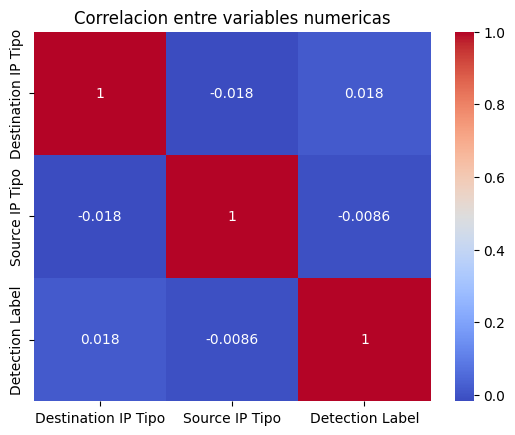

In [18]:
for col in df_ips.select_dtypes(include=['object']).columns:
    df_ips[col] = LabelEncoder().fit_transform(df_ips[col])
sns.heatmap(df_ips[['Destination IP Tipo', 'Source IP Tipo', 'Detection Label']].corr(), cmap='coolwarm', annot=True)
plt.title('Correlacion entre variables numericas')
plt.show()

In [19]:
conteo = df_pivot = df.pivot_table(index="ML Model",
                          columns="Detection Label",
                          aggfunc="size",
                          fill_value=0).reset_index()
conteo

Detection Label                ML Model  Detected  Not Detected
0                   K-Nearest Neighbors      1425          1321
1                   Logistic Regression      1307          1335
2                        Neural Network      1367          1420
3                         Random Forest      1349          1380
4                Support Vector Machine      1303          1459

In [21]:
df["Resultado_bin"] = df["Detection Label"].map({"Detected": 1, "Not Detected": 0})
media_detectados = df.groupby("ML Model")["Resultado_bin"].mean().reset_index(name="Proporcion_detectado")
media_detectados

ML Model  Proporcion_detectado
0     K-Nearest Neighbors              0.518937
1     Logistic Regression              0.494701
2          Neural Network              0.490492
3           Random Forest              0.494320
4  Support Vector Machine              0.471760

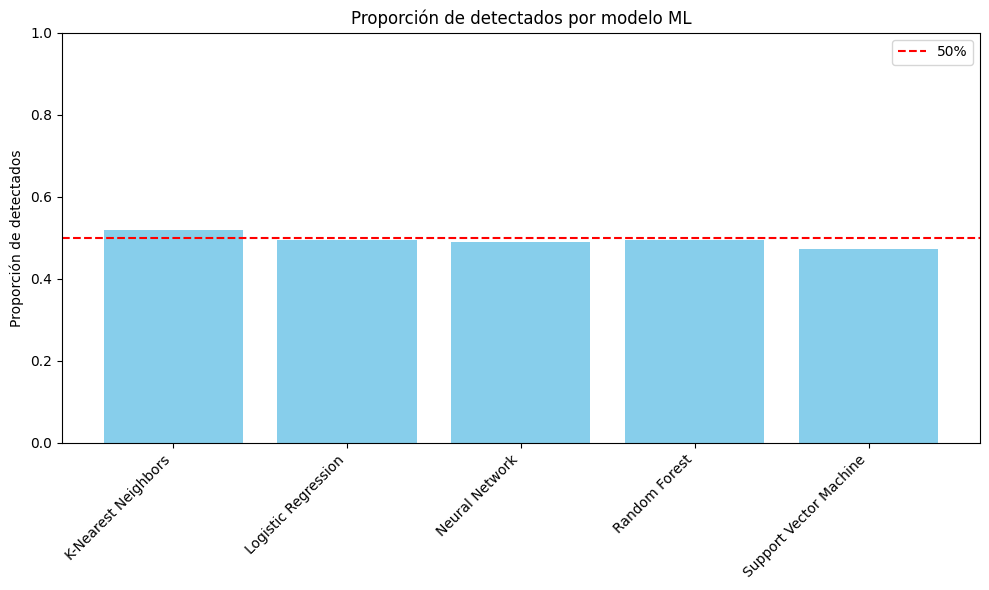

In [22]:
df2 = pd.DataFrame(media_detectados)

# Crear gráfico de barras
plt.figure(figsize=(10,6))
plt.bar(df2["ML Model"], df2["Proporcion_detectado"], color='skyblue')
plt.ylim(0, 1)  # escala de 0 a 1 para proporciones
plt.ylabel("Proporción de detectados")
plt.title("Proporción de detectados por modelo ML")
plt.xticks(rotation=45, ha='right')  # girar etiquetas del eje x
plt.axhline(0.5, color='red', linestyle='--', label='50%')  # referencia 50%
plt.legend()
plt.tight_layout()
plt.show()

*En base a la media podemos notar que de los modelos analizados todos se acercan al 50% de detección lo cual no es favorable si se quisiera implementar dado que de cada 2 ataques solo detectariamos correctamente uno.*

Ahora procederemos a validar en base al confidence Score cual es el modelo que predice con mejor Valor de Confianza

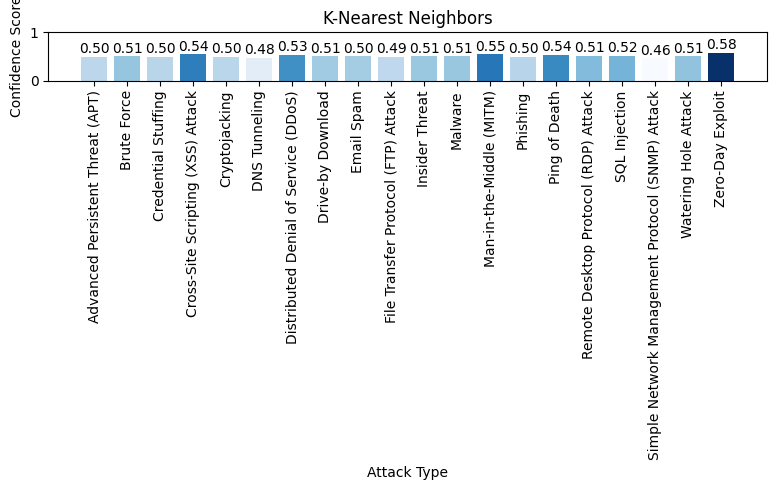

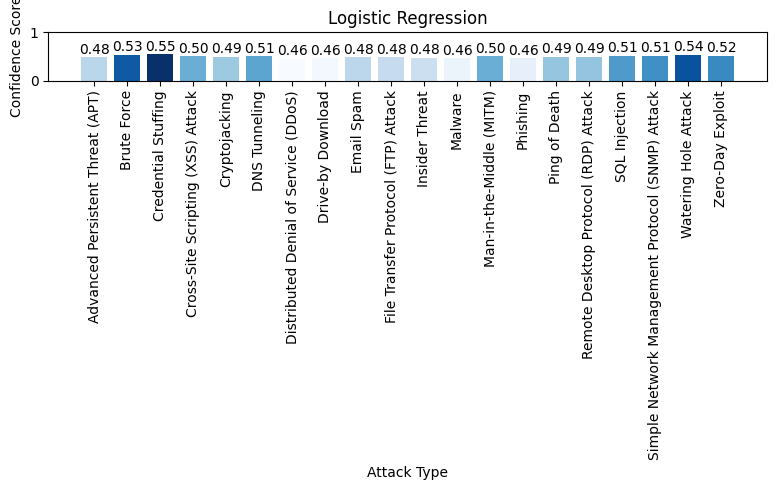

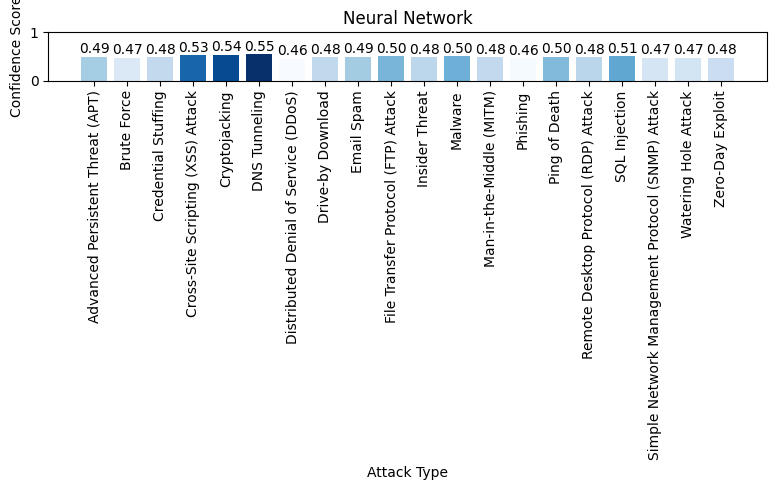

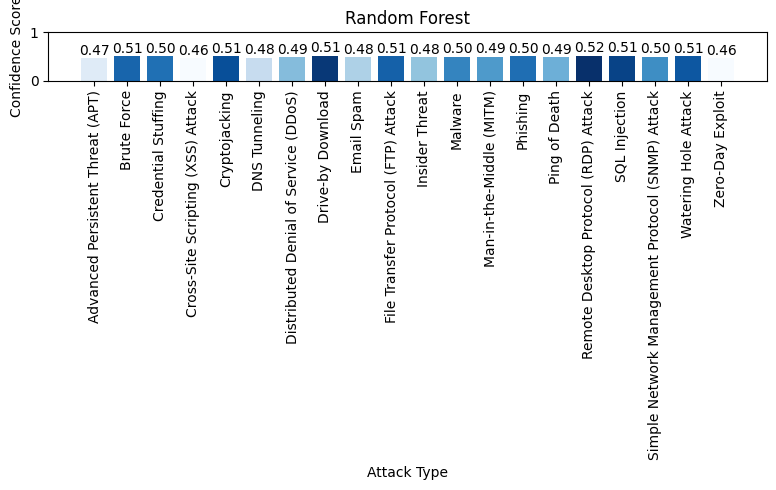

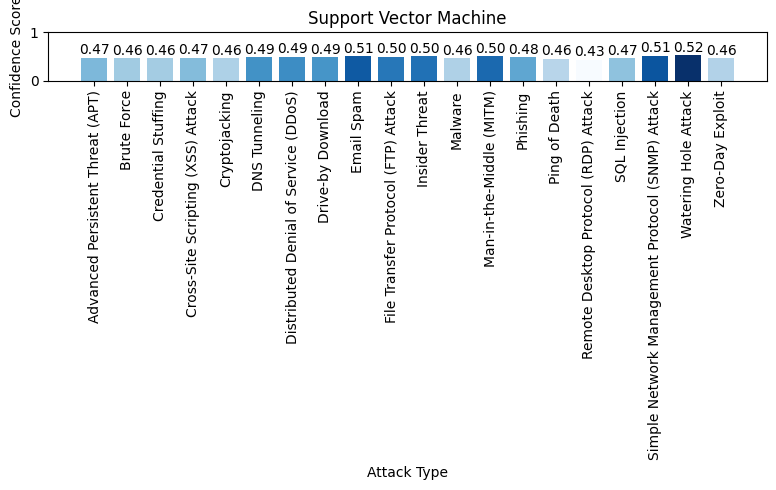

In [23]:
import matplotlib.cm as cm
df3 = pd.DataFrame(df)

# Agrupar por ML Model y Attack Type, calculando promedio
df_mean = df.groupby(["ML Model", "Attack Type"])["Confidence Score"].mean().reset_index()

# Ordenar los tipos de ataque
attack_types_ordered = sorted(df["Attack Type"].unique())

# Lista de modelos
models = df_mean["ML Model"].unique()

# Crear un gráfico por modelo con color según valor
for model in models:
    df_model = df_mean[df_mean["ML Model"] == model]
    df_model = df_model.set_index("Attack Type").reindex(attack_types_ordered).reset_index()

    # Normalizar los valores para usar en colormap
    norm_scores = (df_model["Confidence Score"] - df_model["Confidence Score"].min()) / (df_model["Confidence Score"].max() - df_model["Confidence Score"].min())
    colors = cm.Blues(norm_scores)  # Colormap Blues

    plt.figure(figsize=(8,5))
    bars = plt.bar(df_model["Attack Type"], df_model["Confidence Score"], color=colors)
    plt.ylim(0,1)
    plt.ylabel("Confidence Score")
    plt.xlabel("Attack Type")
    plt.title(f"{model}")
    plt.xticks(rotation=90)  # Etiquetas verticales

    # Agregar valores encima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

En base a este grafico se puede notar que para los modelos de ML se tienen los siguientes resultados:

- K- Nearest Neighborhood:

In [24]:
df

Attack ID        Source IP   Destination IP Source Country  \
0            1.0   68.156.227.194   194.91.121.112          India   
1            2.0   249.221.229.41    3.207.120.235        Germany   
2            4.0   154.55.209.171    132.115.33.82            USA   
3            5.0    106.61.204.27     40.61.49.130         France   
4            6.0  144.190.250.125     34.68.66.192    South Korea   
...          ...              ...              ...            ...   
13784    15227.0    38.237.99.102   251.45.179.157         Brazil   
13785    15228.0   169.184.180.93    191.13.68.118         Brazil   
13786    15229.0     188.2.68.106  152.124.229.240         Russia   
13787    15230.0   40.253.111.120    154.88.58.220         France   
13788    15231.0    182.60.168.17   133.122.188.52          Japan   

      Destination Country Protocol  Source Port  Destination Port  \
0                     USA     ICMP      16824.0           53410.0   
1                     USA      TCP      23977.0           31745.0   
2                   China      UDP      36556.0           38880.0   
3                  France      UDP      14724.0           21669.0   
4                 Germany      TCP      44693.0            6474.0   
...                   ...      ...          ...               ...   
13784         South Korea      TCP      39208.0           47509.0   
13785              Russia     ICMP      41197.0             977.0   
13786               Japan      UDP       7523.0            9871.0   
13787               India      TCP      29354.0           35391.0   
13788                  UK      UDP      48382.0           26815.0   

                             Attack Type  Payload Size (bytes)  \
0                            Brute Force                3936.0   
1       Advanced Persistent Threat (APT)                2870.0   
2      Cross-Site Scripting (XSS) Attack                3833.0   
3                         Insider Threat                4301.0   
4                   Watering Hole Attack                4569.0   
...                                  ...                   ...   
13784                Credential Stuffing                  19.0   
13785                            Malware                 389.0   
13786                           Phishing                2751.0   
13787                      Ping of Death                3532.0   
13788           Man-in-the-Middle (MITM)                4420.0   

      Detection Label  Confidence Score                ML Model  \
0            Detected          0.600507     K-Nearest Neighbors   
1            Detected          0.524150     K-Nearest Neighbors   
2        Not Detected          0.238944          Neural Network   
3        Not Detected          0.122334          Neural Network   
4            Detected          0.970895          Neural Network   
...               ...               ...                     ...   
13784    Not Detected          0.176086  Support Vector Machine   
13785    Not Detected          0.243001          Neural Network   
13786    Not Detected          0.466981  Support Vector Machine   
13787    Not Detected          0.444064     Logistic Regression   
13788    Not Detected          0.395014          Neural Network   

          Affected System Port Type  Resultado_bin  
0           Cloud Storage     Other              1  
1          Network Router     Other              1  
2             Workstation     Other              0  
3             Workstation     Other              0  
4      Application Server     Other              1  
...                   ...       ...            ...  
13784        Email Server     Other              0  
13785     Database Server     Other              0  
13786          IoT Device     Other              0  
13787     Database Server     Other              0  
13788          IoT Device     Other              0  

[13666 rows x 16 columns]

## Creación de Modelo de ML

In [27]:
from sklearn.preprocessing import LabelEncoder

# Copiamos el dataframe
df_ml = df4.copy()

# 1. Codificar Detection (binario)
df_ml["Detection_bin"] = df_ml["Detection Label"].map({"Detected":1, "Not Detected":0})

# 2. Codificar Attack Type (multiclase)
le_attack = LabelEncoder()
df_ml["Attack_Type_bin"] = le_attack.fit_transform(df_ml["Attack Type"])

# 3. Codificar todas las variables categóricas
for col in df_ml.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))

# 4. Definir features automáticamente (todas menos target)
targets = ["Detection_bin", "Attack_Type_bin"]
features = [col for col in df_ml.columns if col not in targets]

X = df_ml[features]
y_detection = df_ml["Detection_bin"]
y_attack = df_ml["Attack_Type_bin"]


In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
#Pipeline escalable con red neuronal

#Ya con X_scaled, podemos crear un modelo que funcione tanto para detección como para attack type:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# ====== Detection (binario) ======
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(
    X_scaled, y_detection, test_size=0.3, stratify=y_detection, random_state=42
)

model_det = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_det.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # binario
])

model_det.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_det.fit(X_train_det, y_train_det, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# ====== Attack Type (multiclase) ======
from tensorflow.keras.utils import to_categorical
import numpy as np

num_classes = len(np.unique(y_attack))
y_attack_cat = to_categorical(y_attack, num_classes)

X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_scaled, y_attack_cat, test_size=0.3, stratify=y_attack, random_state=42
)

model_attack = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_attack.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # multiclase
])

model_attack.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_attack.fit(X_train_attack, y_train_attack, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9563 - loss: 0.1902 - val_accuracy: 1.0000 - val_loss: 6.1840e-04
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.2648e-04
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.6176e-04 - val_accuracy: 1.0000 - val_loss: 4.9107e-05
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.9520e-04 - val_accuracy: 1.0000 - val_loss: 2.3224e-05
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 7.4641e-04 - val_accuracy: 1.0000 - val_loss: 3.0086e-05
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 1.3203e-04 - val_accuracy: 1.0000 - val_loss: 9.6688e-06
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.3489e-05 - val_accuracy: 1.0000 - val_loss: 5.3451e-06
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1025 - loss: 2.7818 - val_accuracy: 0.2900 - val_loss: 1.9513
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2520 - loss: 1.9298 - val_accuracy: 0.3882 - val_loss: 1.5592
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3214 - loss: 1.6384 - val_accuracy: 0.5172 - val_loss: 1.3114
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4163 - loss: 1.4161 - val_accuracy: 0.6714 - val_loss: 1.0975
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4654 - loss: 1.2551 - val_accuracy: 0.7294 - val_loss: 0.9524
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5029 - loss: 1.1256 - val_accuracy: 0.6938 - val_loss: 0.8355
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5631 - loss: 1.0076 - val_accuracy: 0.8448 - val_loss: 0.7217
Epoch 8/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5862 - loss: 0.9467 - val_accuracy: 0.8929 - val_

En este caso se creo dos entrenamientos distintos en la red neuronal, en el primero tomamos el valor de Detection Bin y desde la primera Epoca visualizamos que tenia un accuracy de 1, lo cual indica que existia fuga de datos dado que el dataset cuenta con la información muy correlacionada y daria la impresion de un modelo "perfecto", sin emabargo, este no es el caso real. Por otro lado, en el segundo entrenamiento tomamos el valor de Attack_Type_bin para predecir el tipo de ataque y aqui empezamos en un accuracy de 0,29 y fuimos aproximandonos a 1 con las 30 etapas, lo cual indica un aprendizaje mas real que se acerca a un comportamiento esperando para un red neuronal aprendiendo.

In [33]:
#Durante el entrenamiento(model.fit)

history_det = model_det.fit(
    X_train_det, y_train_det,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.5926e-06 - val_accuracy: 1.0000 - val_loss: 1.7470e-07
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.6036e-06 - val_accuracy: 1.0000 - val_loss: 1.4479e-07
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.5705e-06 - val_accuracy: 1.0000 - val_loss: 1.1692e-07
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.9853e-06 - val_accuracy: 1.0000 - val_loss: 9.2977e-08
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.4676e-06 - val_accuracy: 1.0000 - val_loss: 7.9554e-08
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.3767e-06 - val_accuracy: 1.0000 - val_loss: 6.4833e-08
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.5588e-06 - val_accuracy: 1.0000 - val_loss: 5.4128e-08
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

In [34]:
#Predicciones y evaluación (Detección binaria)
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred_det = (model_det.predict(X_test_det) > 0.5).astype("int32")
y_proba_det = model_det.predict(X_test_det).ravel()

print(confusion_matrix(y_test_det, y_pred_det))
print(classification_report(y_test_det, y_pred_det, target_names=["Not Detected","Detected"]))
print("ROC-AUC:", roc_auc_score(y_test_det, y_proba_det))

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2074    1]
 [   0 2025]]
              precision    recall  f1-score   support

Not Detected       1.00      1.00      1.00      2075
    Detected       1.00      1.00      1.00      2025

    accuracy                           1.00      4100
   macro avg       1.00      1.00      1.00      4100
weighted avg       1.00      1.00      1.00      4100

ROC-AUC: 0.9997590361445784


In [35]:
#Predicciones y evaluación (Multiclase: Attack Type)
y_pred_attack = np.argmax(model_attack.predict(X_test_attack), axis=1)

print(confusion_matrix(np.argmax(y_test_attack, axis=1), y_pred_attack))
print(classification_report(np.argmax(y_test_attack, axis=1), y_pred_attack, target_names=le_attack.classes_))

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[206   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  3 211   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 209   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 206   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0 204   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0 203   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0 212   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0 198   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0 208   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0 188   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 218   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   

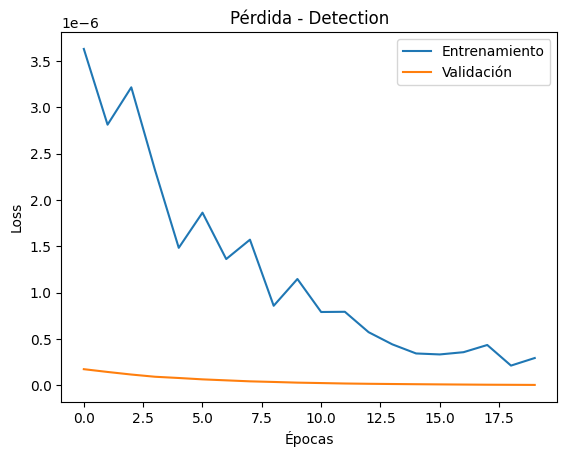

In [36]:
#Visualizar curvas de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history_det.history['accuracy'], label='Entrenamiento')
plt.plot(history_det.history['val_accuracy'], label='Validación')
plt.title('Accuracy - Detection')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

plt.plot(history_det.history['loss'], label='Entrenamiento')
plt.plot(history_det.history['val_loss'], label='Validación')
plt.title('Pérdida - Detection')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

En este grafico de entrenamiento se indica la perdida en fase de entrenamiento y Validación dado que se pudo notar la fuga de información vemos la que el Entrenamiento cae en perdida vertiginosamente, mientras que en el grafico de exactitud podemos notar graficamente que tuvimos exactitud de 1 desde la primera epoca.

In [41]:
#Durante el entrenamiento(model.fit)

history_det2 = model_attack.fit(
    X_train_attack, y_train_attack,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9345 - loss: 0.1806 - val_accuracy: 0.9995 - val_loss: 0.0308
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9322 - loss: 0.1786 - val_accuracy: 0.9963 - val_loss: 0.0491
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9378 - loss: 0.1760 - val_accuracy: 0.9979 - val_loss: 0.0440
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9366 - loss: 0.1806 - val_accuracy: 0.9995 - val_loss: 0.0350
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9313 - loss: 0.1809 - val_accuracy: 0.9990 - val_loss: 0.0358
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9449 - loss: 0.1474 - val_accuracy: 0.9995 - val_loss: 0.0311
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9465 - loss: 0.1478 - val_accuracy: 0.9995 - val_loss: 0.0352
Epoch 8/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9470 - loss: 0.1486 - val_accuracy: 0.

In [42]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

# ====== PREDICCIÓN MULTICLASE ======
y_pred_attack = model_attack.predict(X_test_attack)  # Probabilidades
y_pred_attack_classes = np.argmax(y_pred_attack, axis=1)  # Clase con mayor probabilidad

# ====== REPORTES ======
print("=== Attack Type ===")
print(confusion_matrix(np.argmax(y_test_attack, axis=1), y_pred_attack_classes))
print(classification_report(np.argmax(y_test_attack, axis=1),
                            y_pred_attack_classes,
                            target_names=le_attack.classes_))

# ====== ROC-AUC MULTICLASE ======
# Aquí usamos las probabilidades directamente
roc_auc = roc_auc_score(y_test_attack, y_pred_attack, multi_class="ovr")
print("ROC-AUC (multiclase):", roc_auc)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
=== Attack Type ===
[[206   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 214   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 209   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 206   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0 204   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0 203   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0 212   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0 198   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0 208   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0 188   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 218   0   0   0   0   0   0   0
    0   0]
 [  

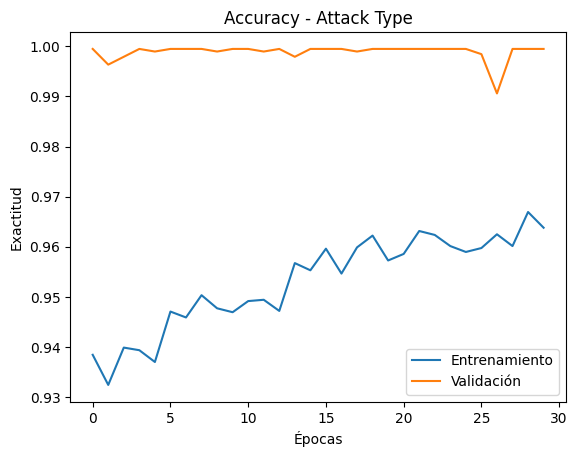

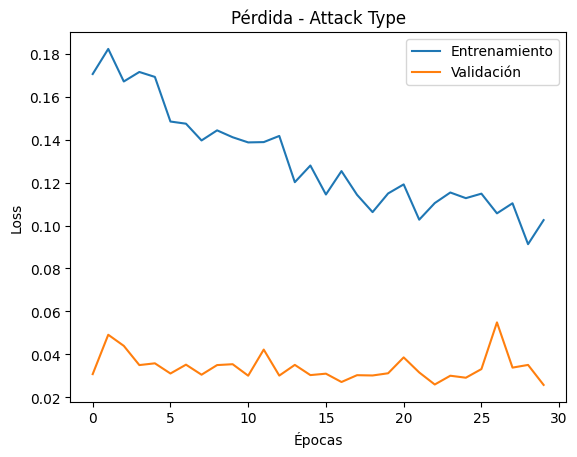

In [44]:
#Visualizar curvas de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history_det2.history['accuracy'], label='Entrenamiento')
plt.plot(history_det2.history['val_accuracy'], label='Validación')
plt.title('Accuracy - Attack Type')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

plt.plot(history_det2.history['loss'], label='Entrenamiento')
plt.plot(history_det2.history['val_loss'], label='Validación')
plt.title('Pérdida - Attack Type')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

Este grafico de entrenamiento del modelo 2 en base al tipo de ataque indica la evolución de la perdida en la fase de Entrenamiento y Validación, podemos ver que a medida que pasan las etapas (Eje x ) la perdida se reduce indicando que el modelo aprende mejor, mientras que la exactitud va mejorando con cada epoca.